In [8]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

## BACKGROUND: QUADRATIC BINARY OPTIMIZATION PROBLEMS

__Combinatorial optimization__: 
Combinatorial optimization problems are ubiquitous across many areas of science and application areas. 
Applications can be found (for example) in logistics, scheduling, planning, and portfolio optimization.
In a nutshell combinatorial optimization problems are problems involving a large number of yes/no decisions with each set of decisions yielding a corresponding objective function value, like a cost or profit value. 
Because of the combinatorial explosion of the solution space with the number of variables, finding good solutions is a daunting task and extremely difficult.  

__QUBO problems__: The QUBO ([Quadratic Unconstrained Binary Optimization](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization)) model unifies a rich variety of NP-hard combinatorial optimization problems: 
Famous examples include Quadratic Assignment Problems, Capital Budgeting Problems, Task Allocation Problems and Maximum-Cut Problems. 
For more details we refer to the excellent review and tutorial on QUBO problems presented in Ref.[5].

__Maximum Cut__: Among the class of QUBO problems, Maximum Cut (MaxCut) is paradigm combinatorial optimization problem. 
Given a graph $G=(V,E)$ with vertex set $V$ and edge set $E$, we seek partition of $V$ into two subsets with maximum cut. 
In short, we have to color every node either blue or red and we score a point whenever an edge connects two nodes with different colors. 
We then would like to find the solution with the highest score. 
Applications thereof can be found in, for example, (i) clustering for marketing purposes (segment your customer base into different clusters for targeted marketing) or (ii) portfolio optimization in finance (vertex corresponds to asset, with color referring to sell or buy decisions. 
Again, the problem in this specific graph coloring problem is that there are $2^𝑁$ possible solutions for $N$ nodes (an exponential explosion in possibilities), making it impossible to enumerate all possible candidates for relevant system sizes. 

__Ising Hamiltonian__: Importantly, there is a fundamental correspondence between QUBO problems and Ising problems in physics. 
Specifically, we can encode the Maximum Cut problem as a __minimization problem__ of an Ising Hamiltonian, where the (classical) cost function reads 

$$H_{C}=\sum_{i>j} J_{i,j} z_{i} z_{j},$$

with Ising variables $z_{i}=-1,1$ and the Ising matrix $J$ encoding the weights of the edges. 
For the sake of this discussion, we ignore potential linear terms and constant offsets (that do not affect the optimal solution $z$ anyway). 
In short, the cost Hamiltonian $H_{C}$ assigns a number to every bitstring $z=(z_{1},z_{2},\dots)$, and we would like to find the lowest number possible. 
This will be the optimal assignment and solution to our problem. 

## BACKGROUND: THE QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM

In this notebook we will try to solve for the optimal _classical_ bitstring $z$ using the Quantum Approximate Optimization Algorithm (QAOA). 
To this end, we first promote the classical spin variables $z_{i}=-1,1$ to quantum-mechanical variables $\sigma_{i}^{z}$ (with the Pauli matrix $\sigma_{i}^{z}$ representing the observable corresponding to spin along the $z$ coordinate axis in three-dimensional Euclidean space $\mathbb{R}^{3}$). 
This leads to the following quantum mechanical cost Hamiltonian encoding the optimization problem

$$\hat{H}_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z},$$

which can be written as a matrix of size $(2^{N}, 2^{N})$ with diagonal elements only corresponding to all possible classical values for the cost function $H_{C}$. 
The ground state of $\hat{H}_{C}$ corresponds to the optimal solution of the classical combinatorial problem.

__QAOA ansatz__: Finding this ground state is generically hard. 
To approximate this groundstate, QAOA prepares a parametrized ansatz state (corresponding to a parameterized  gate  sequence),  whose  parameters  are iteratively updated by a classical optimizer in a closed loop. 
Specifically, QAOA involves a specific ansatz wavefunction parametrized by a parameter family $(\vec{\beta}, \vec{\gamma})$, embedded into a larger classical optimization loop to find the optimal values for these parameters. 
Approximate solutions to the problem class considered here can be found by preparing the variational state 

$$|\gamma, \beta \rangle = U_{x}(\beta_{p})U_{zz}(\gamma_{p}) \cdots U_{x}(\beta_{1})U_{zz}(\gamma_{1}) |s\rangle$$

with single qubit rotations induced by $U_{x}(\beta) = \exp(-i\beta \sum_{i}\sigma_{i}^{x})$, 
and interactions described by $U_{zz}(\gamma) = \exp(-i\gamma H_{C})$,
starting initially from a product of $\sigma^{x}$ eigenstates, i.e.,
$|s\rangle =|-,-,\dots\rangle$, with $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
The family of states $|\gamma, \beta \rangle$ is prepared by alternating single-qubit operations $U_{x}(\beta_{p})$ with targeted spin-spin interactions generated by the cost Hamiltonian $H_{C}$. 
The depth $p$ can be interpreted as a hyperparameter. 
For $p$ layers of QAOA blocks, there are $2p$ classical parameters to optimize over, 
since each layer $k$ is characterized by just two variational parameters, $\gamma_{k}$ and $\beta_{k}$. 
The preparation step outlined above is followed by a measurement in the computational basis, giving a classical string $z$, with which one can evaluate the objective function $H_{C}$ of the underlying combinatorial problem at hand. 
Taking several measurements shots one can build the expectation value $E(\beta, \gamma) = \langle H_{C} \rangle$ that we report as the objective function to the classical minimizer (while other choices could be possible as well). 
Repeating this procedure will provide an optimized string $z$, with the quality of the result improving as the depth of the quantum circuit $\sim 2p$ is increased. 
In fact, in principle (in the absence of noise and other imperfections), QAOA can reach the global optimum of any cost function in the limit $p \rightarrow \infty$, approaching the adiabatic protocol. 
Thus, in theory the computational power of QAOA increases with $p$, but in practice the number of layers that can be executed without errors on NISQ devices is limited due noise and imperfections. 

__Optimization__: Since we are primarily interested in solving the classical optimization problem, within this routine it is sufficient to keep track of the best classical bitstring. 
This means that the wavefunction prepared by the quantum circuit $|\gamma, \beta \rangle$ has to have some overlap with the optimal solution $|z^{*} \rangle$ that we can read out as bitstring $z^{*}$ in the measurement shots. 
To this end, in principle (i.e., without any training), we could just sample from a completely uniform state that is prepared in a superposition of all computational basis states, as prepared by applying Hadamard gates to all qubits: $|\mathrm{uniform}\rangle = 1/\sqrt{2^{N}}\sum_{i}|z_{i}\rangle$. 
In that case (assuming a single optimal solution) the success probability per shot amounts to $p_{\mathrm{success}}=1/2^{N}$. 
We can then amplify our success chances by just taking many measurement shots. 
For large systems, however, this approach is not scalable as we would need to take an exponentially increasing number of measurements. 
That is why we train our circuits, update the parameters, with the goal to increase our success chances to find the optimal bitstring. 
We can quantify our success chances as follows. 
For a given wavefunction $|\gamma, \beta \rangle$ the probability to find the optimal solution in a single shot is given by 

$$ p_{\mathrm{success}}(\gamma, \beta) = |\langle z^{*}|\gamma, \beta \rangle |^{2},$$

where $z^{*}$ denotes the optimal bitstring. 
If we perform $M$ repeated measurements, the overall probability $P$ for observing this solution at least once is given by 

$$ P = 1 - (1-p_{\mathrm{success}}(\gamma, \beta))^{M}, $$ 

since the term $(1-p_{\mathrm{success}}(\gamma, \beta))^{M}$ gives the probability of _not_ obtaining $z^{*}$ in repeated $M$ trials. 
Therefore, to have an overall success chance up to $\epsilon$ close to 100%, i.e., $P \geq 1-\epsilon$, the number of required shots has to be 

$$ M \geq \frac{\log(\epsilon)}{\log(1-p_{\mathrm{success}}(\gamma, \beta))}.$$

Let us illustrate this results as follows: 
If we do not know anything and just resort to a uniform superposition $|\mathrm{uniform}\rangle$, for a small system with $N=10$ qubits we can find the optimal solutions with 80% success probability by taking at least $\sim 1650$ shots. 
For just $N=20$ qubits, however, this number amounts to $\sim 1.7 \times 10^{6}$, making this naive approach unfeasible. 
Conversely, if we can train the quantum circuit to obtain $p_{\mathrm{success}}(\gamma, \beta) \sim 0.1$, we only need $\sim 15$ shots to have $P\geq 80\%$. 
Below we will track and illustrate the best classical optimum as our algorithm proceeds towards a local or (ideally) global optimum.  

__Objective function__: Finally, the quality of our solution will be assessed via the approximation ratio $r^{*}$ defined as:

$$ r^{*} = \frac{\text{Minimum energy calculated by QAOA}}{\text{True minimum eigenvalue of the cost Hamiltonian}} $$


## IMPORTS and SETUP

In [9]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import time
from datetime import datetime
import pickle
import random

# magic line for producing visualizations in notebook
%matplotlib inline

In [10]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(a=seed)

# switch to trigger writing training results to disk
store_results = False
# switch to trigger printing results of each optimization cycle
verbose = True

In [11]:
# AWS imports: Import Braket SDK modules
from braket.circuits import FreeParameter
from braket.devices import LocalSimulator

In [12]:
from utils_classical import *

In [13]:
# Set up device: Local Simulator
device = LocalSimulator()

In [14]:
## example code for other backends
# from braket.aws import AwsDevice
# from braket.devices import Devices
## choose the on-demand simulator to run your circuit
# device = AwsDevice(Devices.Amazon.SV1)
## choose the Rigetti device to run your circuit
# device = AwsDevice(Devices.Rigetti.Ankaa2)
## choose the Ionq device to run your circuit
# device = AwsDevice(Devices.IonQ.Aria1)
## choose the IQM device to run your circuit
# device = AwsDevice(Devices.IQM.Garnet)

## PROBLEM SETUP

We consider a graph coloring problem.
Given a graph $G=(V,E)$, made of a set vertices (also called nodes) $V$ and edges $E$, our goal is to color each node red or blue, then score a point for each node that is next to a node of different color. 
We strive to find the optimal coloring that scores the largest number of points.
To this end, we will address the dual problem of finding the minimum energy of the corresponding Ising Hamiltonian. 
To get started, we first use the open-source ```networkx``` library to visualize the problem graph. 
Feel free to play with the parameters $n$ (for the number of nodes) and $m$ (for the number of edges) below to consider other graphs of your choice.

For fast demonstration, I'll just consider an equally weighted 4-node graph

{(0, 1): Text(0.5684265317251794, 0.09579363887436414, '1'),
 (0, 3): Text(-0.24338908643815685, 0.12742301537238337, '1'),
 (0, 2): Text(-0.18818438183666367, -0.20015350146533228, '1'),
 (2, 3): Text(-0.5684265317251794, -0.09579363887436404, '1')}

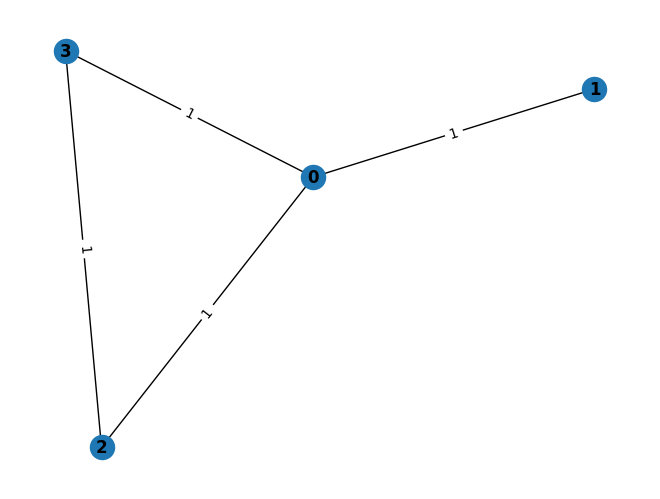

In [15]:
# # setup Erdos Renyi graph
# n = 10  # number of nodes/vertices
# m = 20  # number of edges

# # define graph object
# G = nx.gnm_random_graph(n, m, seed=seed)
# # G = nx.erdos_renyi_graph(n=n, p=0.6, seed=seed)
# # positions for all nodes
# pos = nx.spring_layout(G)

# # choose random weights
# for (u, v) in G.edges():
#     G.edges[u,v]['weight'] = np.round(random.uniform(0, 1),4)

# # draw graph
# nx.draw(G, pos, with_labels = True, font_weight = 'bold')
# labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)
# plt.show()

edges = [(0,1,1),(2,3,1),(3,0,1), (2,0,1), (0,3,1)]
nodes = []
for edge in edges:
    start_node = edge[0]
    end_node = edge[1]
    if (start_node not in nodes):
        nodes.append(start_node)
    if (end_node not in nodes):
        nodes.append(end_node)
num_nodes = len(nodes)
G = nx.Graph() 
G.add_nodes_from(nodes)
G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels = True, font_weight = 'bold')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels = labels)

In [16]:
# set Ising matrix 
Jfull = nx.to_numpy_array(G)

# get off-diagonal upper triangular matrix
J = np.triu(Jfull, k=1).astype(np.float64)

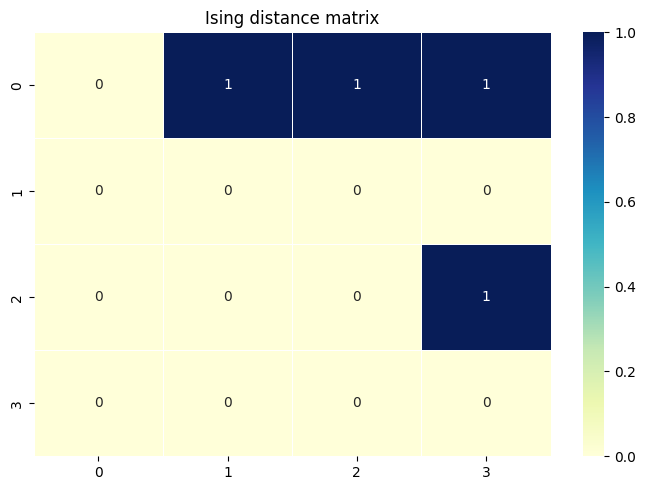

In [17]:
# plot Ising matrix
plt.figure(1, figsize=[7, 5])
sns.heatmap(J, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();

## IMPLEMENTATION OF QAOA WITH BRAKET 

In this section we load a set of useful helper functions that we will explain in detail below. 
Specifically in ```utils_qaoa.py``` we provide simple building blocks for the core modules of our QAOA algorithm, that is (i) a function called ```circuit``` that defines the parametrized ansatz, (ii) a function called ```objective_function``` that takes a list of variational parameters as input, and returns the cost associated with those parameters and finally (iii) a function ```train``` to run the entire QAOA algorithm for given ansatz. 
This way we can solve the problem in a clean and modular approach.
Here, we show in markdown the definition of the parametrized QAOA circuit. 
For more details, see the corresponding file ```utils_qaoa.py```. 

In [18]:
from utils_qaoa import *

```python
# function to implement evolution with driver Hamiltonian
def driver(beta, n_qubits):
    """
    Returns circuit for driver Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()
    
    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2*beta)
        circ.add(gate)
    
    return circ


# helper function for evolution with cost Hamiltonian
def cost_circuit(gamma, n_qubits, ising):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    # get all non-zero entries (edges) from Ising matrix 
    idx = ising.nonzero()
    edges = list(zip(idx[0], idx[1]))
    
    for qubit_pair in edges:
        # get interaction strength
        int_strength = ising[qubit_pair[0], qubit_pair[1]]
        # for Rigetti we decompose ZZ using CNOT gates
        if 'Aspen' in device.name:
            gate = ZZgate(qubit_pair[0], qubit_pair[1], gamma*int_strength)
            circ.add(gate)
        # classical simulators and IonQ support ZZ gate
        else:
            gate = Circuit().zz(qubit_pair[0], qubit_pair[1], angle=2*gamma*int_strength)
            circ.add(gate)

    return circ


# function to build the QAOA circuit with depth p
def circuit(params, n_qubits, ising):
    """
    function to return full QAOA circuit
    """

    # initialize qaoa circuit with first Hadamard layer: for minimization start in |->
    circ = Circuit()
    X_on_all = Circuit().x(range(0, n_qubits))
    circ.add(X_on_all)
    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add circuit layers
    for mm in range(circuit_length):
        circ.add(cost_circuit(gammas[mm], n_qubits, ising))
        circ.add(driver(betas[mm], n_qubits))

    return circ

```

## VISUALIZATION OF THE QAOA ANSATZ

Let us first visualize our parametrized QAOA ansatz for a small number of qubits and fixed (i.e., not optimized) parameters. 
For convenience, the parameters are displayed in the circuit (up to a factor of $2$ we have added in our ansatz definition). 
First we prepare the state $|0,0,\dots\rangle \rightarrow |-,-,\dots\rangle$, with the superposition state $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
Following the discussion above, we choose to start out with this state as it is the minimal energy state of the simple driver Hamiltonian $H_{B}$. 
This state preparation is followed by one layer of the QAOA ansatz, consisting of evolution with the cost Hamiltonian by $\exp(-i\gamma H_{C})= \prod_{j,l}\exp(-i\gamma J_{j,l}\sigma_{j}^{z}\sigma_{l}^{z}) = \prod_{j,l} ZZ_{j,l}(2\gamma J_{j,l})$, followed by the single-qubit driving term, $\exp(-i\beta H_{B})= \prod_{j} \exp(-i\beta \sigma_{j}^{x})= \prod_{j} R_{j}^{(x)}(2\beta)$.
Note that the circuit definition depends on the ```device``` object, as the implementation of the ZZ gate depends on the specific gate set supported by the device.  

In [19]:
# create parameters
gammas = [FreeParameter('gamma')]
betas = [FreeParameter('beta')]
params = gammas + betas

# for demonstration purposes use small Ising matrix
J_sub = np.array([[0, 1], [0, 0]])
N = J_sub.shape[0]

# get circuit ansatz
my_simple_circuit = circuit(params, device, N, J_sub)

# print test ansatz circuit
print('Printing test circuit:')
print(my_simple_circuit)

Printing test circuit:
T  : │  0  │  1  │       2       │      3       │
      ┌───┐ ┌───┐ ┌─────────────┐ ┌────────────┐ 
q0 : ─┤ X ├─┤ H ├─┤ ZZ(2*gamma) ├─┤ Rx(2*beta) ├─
      └───┘ └───┘ └──────┬──────┘ └────────────┘ 
      ┌───┐ ┌───┐ ┌──────┴──────┐ ┌────────────┐ 
q1 : ─┤ X ├─┤ H ├─┤ ZZ(2*gamma) ├─┤ Rx(2*beta) ├─
      └───┘ └───┘ └─────────────┘ └────────────┘ 
T  : │  0  │  1  │       2       │      3       │

Unassigned parameters: [beta, gamma].


We see that our ansatz produces the expected result for shallow QAOA with $p=1$. 
We run one more sanity check for $p=2$ below. 

In [20]:
# set number of qubits and fix parameters
gammas = [FreeParameter('gamma_1'), FreeParameter('gamma_2')]
betas = [FreeParameter('beta_1'), FreeParameter('beta_2')]
params = gammas + betas

# for demonstration purposes use small Ising matrix
J_sub = np.array([[0, 1], [0, 0]])
N = J_sub.shape[0]

# get circuit ansatz
my_simple_circuit = circuit(params, device, N, J_sub)

# print test ansatz circuit
print('Printing test circuit:')
print(my_simple_circuit)

Printing test circuit:
T  : │  0  │  1  │        2        │       3        │        4        │       5        │
      ┌───┐ ┌───┐ ┌───────────────┐ ┌──────────────┐ ┌───────────────┐ ┌──────────────┐ 
q0 : ─┤ X ├─┤ H ├─┤ ZZ(2*gamma_1) ├─┤ Rx(2*beta_1) ├─┤ ZZ(2*gamma_2) ├─┤ Rx(2*beta_2) ├─
      └───┘ └───┘ └───────┬───────┘ └──────────────┘ └───────┬───────┘ └──────────────┘ 
      ┌───┐ ┌───┐ ┌───────┴───────┐ ┌──────────────┐ ┌───────┴───────┐ ┌──────────────┐ 
q1 : ─┤ X ├─┤ H ├─┤ ZZ(2*gamma_1) ├─┤ Rx(2*beta_1) ├─┤ ZZ(2*gamma_2) ├─┤ Rx(2*beta_2) ├─
      └───┘ └───┘ └───────────────┘ └──────────────┘ └───────────────┘ └──────────────┘ 
T  : │  0  │  1  │        2        │       3        │        4        │       5        │

Unassigned parameters: [beta_1, beta_2, gamma_1, gamma_2].


## QAOA SIMULATION ON LOCAL SCHROEDINGER SIMULATOR

We are now all set to run some QAOA simulation experiments. 
First of all, you can play and experiment yourself with the number of qubits $N$. 
Secondly, you may also experiment with the classical optimizer. 
Since we are using an off-the-shelf, black-box ```scipy``` minimizer (as described in more detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), you can simply swap between different optimizers by setting the ```OPT_METHOD``` parameter below. 
Some popular options readily available within this library include *Nelder-Mead*, *BFGS* and *COBYLA*. 
As a precautionary warning, note that the classical optimization step may get stuck in a local optimum, rather than finding the global minimum for our parametrized QAOA ansatz wavefunction. 
To address this issue, we may run several optimization loops, starting from different random parameter seeds. 
While this brute-force approach does not provide any guarantee to find the global optimum, from a pragmatic point of view at least it does increase the odds of finding an acceptable solution, at the expense of potentially having to run many more circuits on the simulator or QPU, respectively.
Finally, the optimization loop may require the execution of many individual quantum tasks (i.e., single circuit executions for fixed parameters). 
For example, when choosing the classical [Powell](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html#optimize-minimize-powell) optimizer for the graph considered here, we find $\sim 270$ cycles in the for loop. 
For the local simulator device chosen here by default this is not an issue, but if you run this algorithm on any QPU you may want to adjust the ```maxfev``` parameter to control the maximum allowed number function evaluations (compare comment in the next code block below).

In [21]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 12  # circuit depth for QAOA
SHOTS = 1000  # number measurements to make on circuit
OPT_METHOD = 'COBYLA'  # SLSQP, COBYLA, Nelder-Mead, BFGS, Powell, ...

# set up the problem
n_qubits = J.shape[0]

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))

# set tracker to keep track of results
tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_bitstrings': [],                 # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': [],                         # Track parameters
    'ratio': [],                          # The benchmarking metric
    'ratio_min': [],                      # Best possible solution during measurement
    'ratio_shot': [],                     # The ratio for the optimal solution over all measurements
    'prob': []                            # Record prob of measurement
}

# set options for classical optimization
options = {'disp': True, 'maxiter': 50}

In [22]:
##################################################################################
# run QAOA optimization on graph 
##################################################################################

print('Circuit depth hyperparameter:', DEPTH)
print('Problem size:', n_qubits)

# kick off training
start = time.time()
result_energy, result_angle, tracker = train(
    device = device, options=options, p=DEPTH, ising=J, n_qubits=n_qubits, n_shots=SHOTS, 
    opt_method=OPT_METHOD, tracker=tracker, verbose=verbose, G=G)
end = time.time()

# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energy:', tracker['optimal_energy'])
print('Optimal classical bitstring:', tracker['optimal_bitstring'])

##################################################################################
# Compute output and dump to pickle
##################################################################################

if store_results:
    out = {'p': DEPTH, 'N': n_qubits,
           'ENERGY_OPTIMAL': tracker['optimal_energy'], 'BITSTRING': tracker['optimal_bitstring'],
           'result_energy': result_energy, 'result_angle': result_angle}

    # store results: dump output to pickle with timestamp in filename
    time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
    results_file = 'results-'+time_now+'.pkl'
    print(f'Writing results to file: {results_file}')
    pickle.dump(out, open(results_file, "wb"))
    
    # you can load results as follows
    # out = pickle.load(open(results_file, "rb"))

Circuit depth hyperparameter: 12
Problem size: 4
Starting the training.
OPTIMIZATION for circuit depth p=12, print('Problem size:', 4).
Calling the quantum circuit. Cycle: 1
Minimal energy: -2.0
Optimal classical string: [ 1 -1  1 -1]
Energy expectation value (cost): 1.15
Calling the quantum circuit. Cycle: 2
Minimal energy: -2.0
Optimal classical string: [-1  1 -1  1]
Energy expectation value (cost): -0.362
Calling the quantum circuit. Cycle: 3
Minimal energy: -2.0
Optimal classical string: [ 1 -1 -1  1]
Energy expectation value (cost): 0.466
Calling the quantum circuit. Cycle: 4
Minimal energy: -2.0
Optimal classical string: [-1  1 -1  1]
Energy expectation value (cost): -1.014
Calling the quantum circuit. Cycle: 5
Minimal energy: -2.0
Optimal classical string: [ 1 -1 -1 -1]
Energy expectation value (cost): 2.052
Calling the quantum circuit. Cycle: 6
Minimal energy: -2.0
Optimal classical string: [-1  1  1  1]
Energy expectation value (cost): -0.546
Calling the quantum circuit. Cycle

## POSTPROCESSING AND COMPARISON OF OUR QAOA RESULTS WITH CLASSICAL RESULTS

In this section we visualize the results we have found with QAOA. 
Specifically, we display the results found for the variational parameters $\beta$ and $\gamma$ for every layer in our QAOA ansatz. 
Moreover, we show the solution to our graph coloring problem with every node colored either red or blue (recall that there are just two colors since we solve a _binary_ optimization problem).
Finally, we compare these results to results found classically. 
Ideally, the two results should agree with each other but this is not necessarily the case for several reasons: 
First of all, for the original small toy problem we have set up there are several degenerate classical solutions with the same optimal quality. 
The classical and the QAOA approach may find solutions with different coloring configurations but the same quality (that is energy). 
Secondly, with QAOA we are not guaranteed to find the optimal solutions. 
Specifically, the deeper the circuit, the harder the classical optimization problem, and we may get stuck in a local rather than global optimum. 
One brute-force approach is then to just re-run QAOA with different random initial seeds for the parameters $(\beta, \gamma)$.

In [23]:
# visualize the optimization process
cycles = np.arange(1, tracker['count'])
# optim_classical = tracker['global_energies']
# costs = tracker['costs']
# print information
# info = 'Optimization on graph with n={} vertices, m={} edges, optimized with {} and {} shots per call.'
# print(info.format(n, m, OPT_METHOD, SHOTS))

# plt.plot(cycles, optim_classical, label='gloabl min')
# plt.xlabel('optimization cycle')
# plt.ylabel('best classical minimum')
# plt.plot(cycles, costs, label='energy at each step')
# plt.ylim([min(optim_classical)-0.1, max(costs)])
# plt.legend()
# plt.show()

In [24]:
# # get results for variational angles
# gamma = result_angle[:DEPTH]
# beta = result_angle[DEPTH:]
# # get array [1, 2, ..., p]
# pa = np.arange(1, DEPTH + 1)

# plt.figure(2)
# plt.plot(pa, gamma / np.pi, '-o', label='gamma')
# plt.plot(pa, beta / np.pi, '-s', label='beta')
# plt.xlabel('circuit depth (layer) p')
# plt.ylabel('optimal angles [pi]')
# plt.xticks(pa)
# plt.legend(title='Variational QAOA angles:', loc='upper left')
# plt.show()

Optimal cut found with QAOA: [ 1 -1  1 -1]
Minimal energy found with QAOA: -2.0


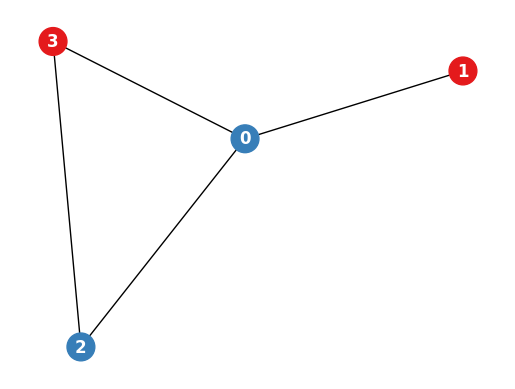

In [25]:
# visualize solution
colorlist = tracker['optimal_bitstring']
print('Optimal cut found with QAOA:', tracker['optimal_bitstring'])
colorlist[colorlist == -1] = 0
# plot_colored_graph(J, N, colorlist, pos)
plot_colored_graph_simple(G, colorlist, pos)
print('Minimal energy found with QAOA:', tracker['optimal_energy'])

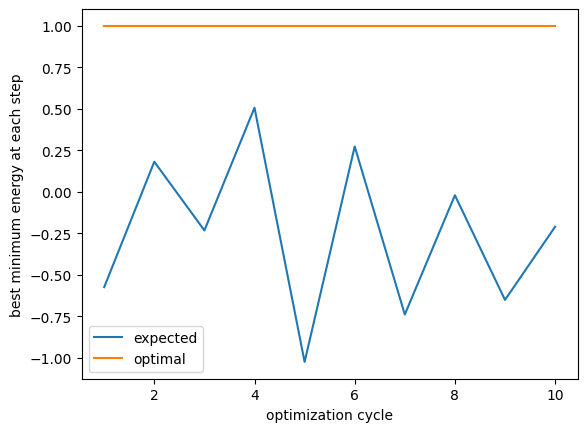

In [26]:
plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(cycles, tracker['ratio'], label='expected')
plt.plot(cycles, tracker['ratio_min'], label='optimal')
plt.legend()
plt.show()

As you can see above, because the measurements contain a lot of 'noisy' solutions. The expected approximation ratio, $r^{*}$ could not reach 1.

The following plots shows the ratio of the shots with optimal solution during the optimization cycle.

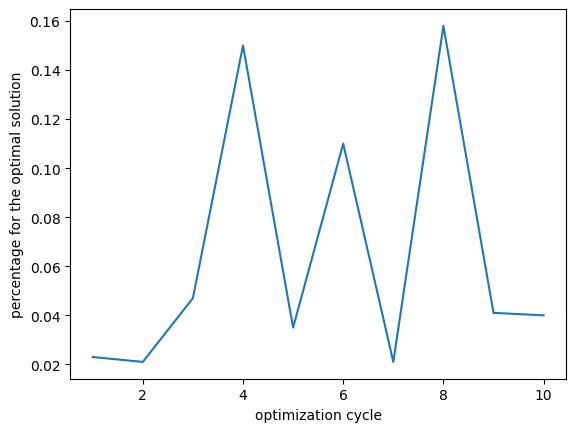

In [27]:
plt.xlabel('optimization cycle')
plt.ylabel('percentage for the optimal solution')
plt.plot(cycles, tracker['ratio_shot'])
plt.show()

In [28]:
# check true solutions bitstring
# Jfull = nx.to_numpy_array(G)

# # get off-diagonal upper triangular matrix
# J = np.triu(Jfull, k=1).astype(np.float64)
# sol = solve_QAOA(G, J)
# print(sol)

# Iteration through different Graphs with different number of nodes

In [29]:
from utils_qaoa import benchmark

benchmark_nodes = benchmark(nodes_list=[4,6,8,10], depth=[4,8,12], shots=1000)

Starting the training.
OPTIMIZATION for circuit depth p=4, print('Problem size:', 4).
Final average energy (cost):
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-7.393232E-01    MAXCV = 0.000000E+00
   X = 2.183199E+00   5.739713E+00   5.102559E+00   3.907665E+00   7.386988E-01
       1.583654E+00   1.419580E+00   2.789894E+00
 -0.7393232
Final angles: [2.18319883 5.73971271 5.1025586  3.90766458 0.7386988  1.58365397
 1.41957971 2.78989425]
Training complete.
Starting the training.
OPTIMIZATION for circuit depth p=8, print('Problem size:', 4).
Final average energy (cost):
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.420394E+00    MAXCV = 0.000000E+00
   X = 3.305101E+00   2.569649E+00   6.040515E+00   3.801141E+00   5.110378E+00
       3.983426E+00   7.234578E-01   4.513538E+00   8.615463E-01   2.524339E+00
       2.215377E+00   1.305912E+00   1.109853E+00   2.598139E+00   1.7

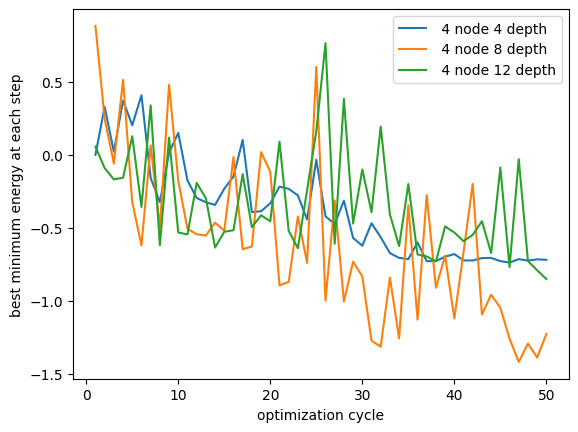

In [39]:
# visualize the optimization process
import numpy as np
import matplotlib.pyplot as plt

costs4_4 = benchmark_nodes['node4']['depth4']['tracker']['costs']
costs4_8 = benchmark_nodes['node4']['depth8']['tracker']['costs']
costs4_12 = benchmark_nodes['node4']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_nodes['node4']['depth4']['tracker']['count']), costs4_4, label=' 4 node 4 depth')
plt.plot(np.arange(1,benchmark_nodes['node4']['depth8']['tracker']['count']), costs4_8, label=' 4 node 8 depth')
plt.plot(np.arange(1,benchmark_nodes['node4']['depth12']['tracker']['count']), costs4_12, label=' 4 node 12 depth')

plt.legend()
plt.show()

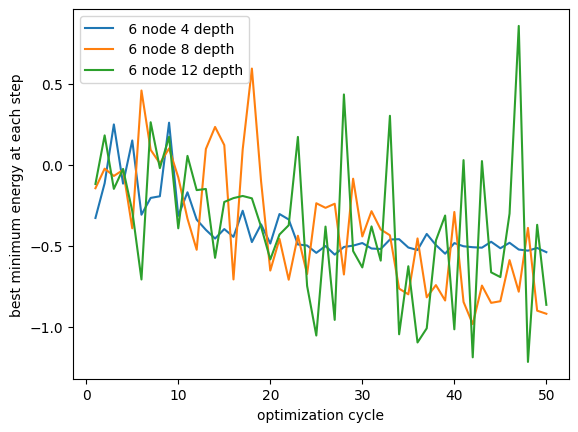

In [31]:
costs6_4 = benchmark_nodes['node6']['depth4']['tracker']['costs']
costs6_8 = benchmark_nodes['node6']['depth8']['tracker']['costs']
costs6_12 = benchmark_nodes['node6']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_nodes['node6']['depth4']['tracker']['count']), costs6_4, label=' 6 node 4 depth')
plt.plot(np.arange(1,benchmark_nodes['node6']['depth8']['tracker']['count']), costs6_8, label=' 6 node 8 depth')
plt.plot(np.arange(1,benchmark_nodes['node6']['depth12']['tracker']['count']), costs6_12, label=' 6 node 12 depth')

plt.legend()
plt.show()

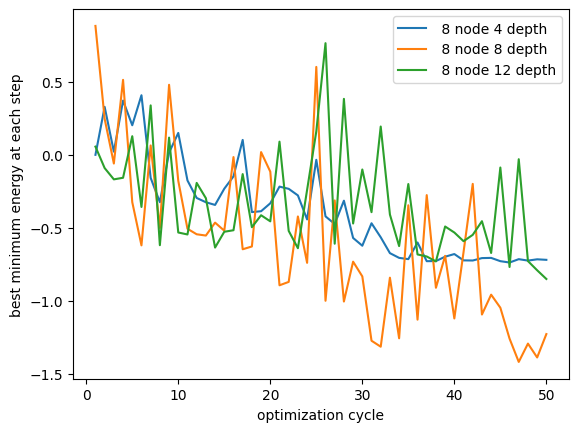

In [32]:
costs8_4 = benchmark_nodes['node8']['depth4']['tracker']['costs']
costs8_8 = benchmark_nodes['node8']['depth8']['tracker']['costs']
costs8_12 = benchmark_nodes['node8']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_nodes['node8']['depth4']['tracker']['count']), costs4_4, label=' 8 node 4 depth')
plt.plot(np.arange(1,benchmark_nodes['node8']['depth8']['tracker']['count']), costs4_8, label=' 8 node 8 depth')
plt.plot(np.arange(1,benchmark_nodes['node8']['depth12']['tracker']['count']), costs4_12, label=' 8 node 12 depth')

plt.legend()
plt.show()

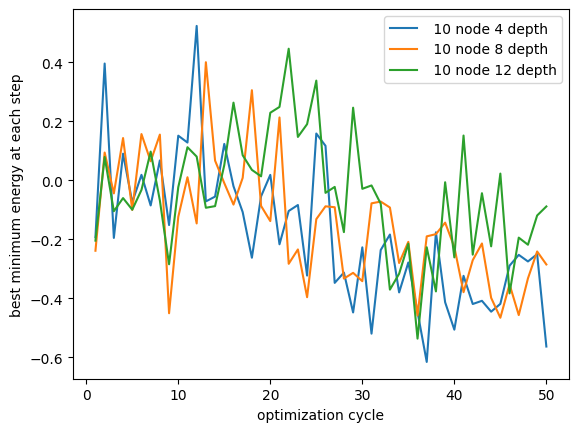

In [33]:
costs10_4 = benchmark_nodes['node10']['depth4']['tracker']['costs']
costs10_8 = benchmark_nodes['node10']['depth8']['tracker']['costs']
costs10_12 = benchmark_nodes['node10']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_nodes['node10']['depth4']['tracker']['count']), costs10_4, label=' 10 node 4 depth')
plt.plot(np.arange(1,benchmark_nodes['node10']['depth8']['tracker']['count']), costs10_8, label=' 10 node 8 depth')
plt.plot(np.arange(1,benchmark_nodes['node10']['depth12']['tracker']['count']), costs10_12, label=' 10 node 12 depth')

plt.legend()
plt.show()

Now we apply the optimization scheme, 'INTERP', introduced in https://arxiv.org/abs/1812.01041.

In [34]:
from utils_qaoa import benchmark

benchmark_with_opt = benchmark(nodes_list=[4,6,8,10], depth=range(4,13), shots=1000, optimization=True)

Starting the training.
OPTIMIZATION for circuit depth p=4, print('Problem size:', 4).
Final average energy (cost):
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-7.393232E-01    MAXCV = 0.000000E+00
   X = 2.183199E+00   5.739713E+00   5.102559E+00   3.907665E+00   7.386988E-01
       1.583654E+00   1.419580E+00   2.789894E+00
 -0.7393232
Final angles: [2.18319883 5.73971271 5.1025586  3.90766458 0.7386988  1.58365397
 1.41957971 2.78989425]
Training complete.
Starting the training.
OPTIMIZATION for circuit depth p=5, print('Problem size:', 4).
Final average energy (cost):
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   50   F =-1.004931E+00    MAXCV = 0.000000E+00
   X = 3.089773E+00   6.167771E+00   6.168213E+00   2.858912E+00   2.034379E+00
       4.868451E-01   1.226580E+00   1.474927E+00   4.545514E-01   1.336048E+00
 -1.0049314
Final angles: [3.08977299 6.16777121 6.16821288 2.85891246

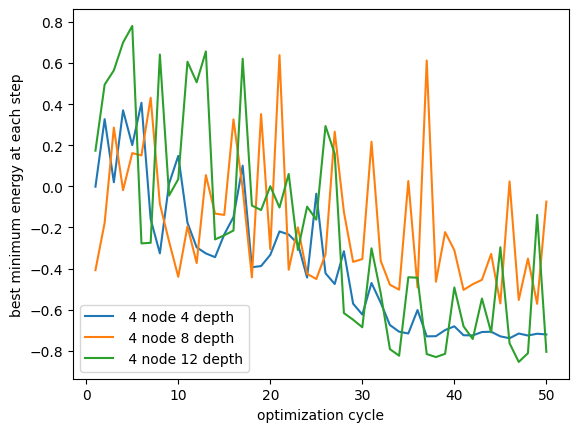

In [35]:
import numpy as np
import matplotlib.pyplot as plt

costs4_4 = benchmark_with_opt['node4']['depth4']['tracker']['costs']
costs4_8 = benchmark_with_opt['node4']['depth8']['tracker']['costs']
costs4_12 = benchmark_with_opt['node4']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_with_opt['node4']['depth4']['tracker']['count']), costs4_4, label=' 4 node 4 depth')
plt.plot(np.arange(1,benchmark_with_opt['node4']['depth8']['tracker']['count']), costs4_8, label=' 4 node 8 depth')
plt.plot(np.arange(1,benchmark_with_opt['node4']['depth12']['tracker']['count']), costs4_12, label=' 4 node 12 depth')

plt.legend()
plt.show()

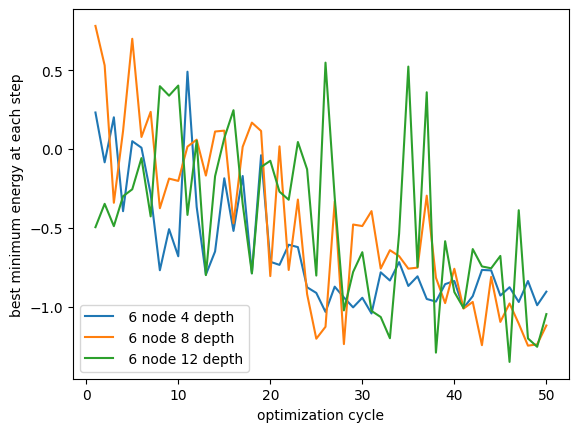

In [36]:
costs6_4 = benchmark_with_opt['node6']['depth4']['tracker']['costs']
costs6_8 = benchmark_with_opt['node6']['depth8']['tracker']['costs']
costs6_12 = benchmark_with_opt['node6']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_with_opt['node6']['depth4']['tracker']['count']), costs6_4, label=' 6 node 4 depth')
plt.plot(np.arange(1,benchmark_with_opt['node6']['depth8']['tracker']['count']), costs6_8, label=' 6 node 8 depth')
plt.plot(np.arange(1,benchmark_with_opt['node6']['depth12']['tracker']['count']), costs6_12, label=' 6 node 12 depth')

plt.legend()
plt.show()

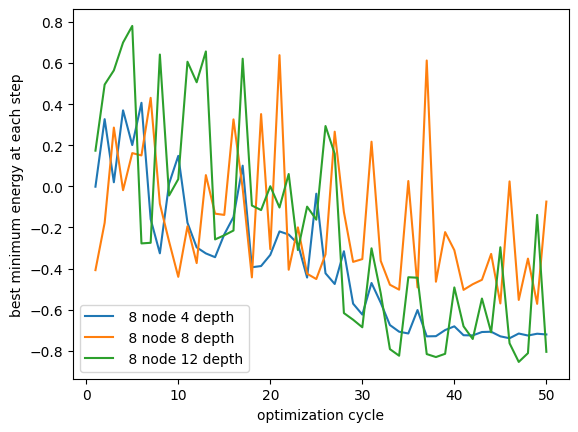

In [37]:
costs8_4 = benchmark_with_opt['node8']['depth4']['tracker']['costs']
costs8_8 = benchmark_with_opt['node8']['depth8']['tracker']['costs']
costs8_12 = benchmark_with_opt['node8']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_with_opt['node8']['depth4']['tracker']['count']), costs4_4, label=' 8 node 4 depth')
plt.plot(np.arange(1,benchmark_with_opt['node8']['depth8']['tracker']['count']), costs4_8, label=' 8 node 8 depth')
plt.plot(np.arange(1,benchmark_with_opt['node8']['depth12']['tracker']['count']), costs4_12, label=' 8 node 12 depth')

plt.legend()
plt.show()

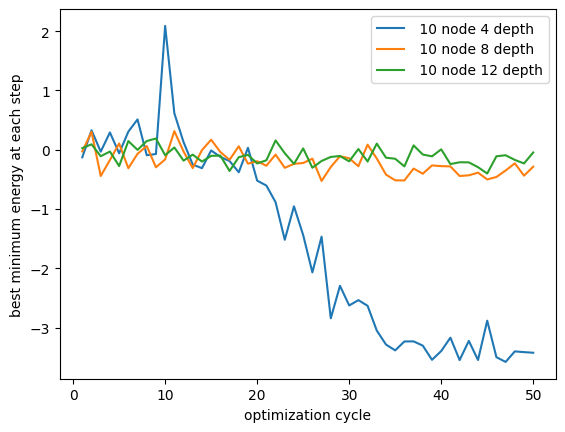

In [38]:
costs10_4 = benchmark_with_opt['node10']['depth4']['tracker']['costs']
costs10_8 = benchmark_with_opt['node10']['depth8']['tracker']['costs']
costs10_12 = benchmark_with_opt['node10']['depth12']['tracker']['costs']

plt.xlabel('optimization cycle')
plt.ylabel('best minimum energy at each step')
plt.plot(np.arange(1,benchmark_with_opt['node10']['depth4']['tracker']['count']), costs10_4, label=' 10 node 4 depth')
plt.plot(np.arange(1,benchmark_with_opt['node10']['depth8']['tracker']['count']), costs10_8, label=' 10 node 8 depth')
plt.plot(np.arange(1,benchmark_with_opt['node10']['depth12']['tracker']['count']), costs10_12, label=' 10 node 12 depth')

plt.legend()
plt.show()